In [1]:
import  gymnasium as gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm
from memory import RandomReplayMemory, PrioritizedReplayMemory
from gridWorldEnv import GridWorldEnv
from train import Agent
from pathos.multiprocessing import ProcessingPool as Pool
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\navid\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
def env_changes(env, ep_num):
    if ep_num == 0:
        env.switch_doors(top_door="close",bottom_door="open")


def parallelied_run(params):
    from train import Agent
    agent = Agent(**params)
    return agent.train()

In [3]:
# running and storing the results of random memory replay with stochasticity as a hyperparameter

parameters_random = {
        "gamma": 0.99,
        "lr": 5e-4,
        "TAU": 0.01,
        "episode_num": 700,
        "batch_size": 64,
        "epsilon_max": 0.1,
        "epsilon_min": 0.1,
        "device": "cpu",
        "max_episode_len": 200,
        "run_env_changes": True, 
        "env_changes": env_changes, #this won't cause non-stationarity in this environment because env_change doesn't change the environment
        # "stochasticity_constant": 0, # hyper-parameter
        "env_name": "GridWorldEnv",
        "device": "cpu",
        "buffer_type": "random",
        "buffer_size": 50_000,
        }

stochasticity_constants_random = [0, 0.2, 0.4]
parameters_random_parallel = []
for stochast in stochasticity_constants_random:
    parameters = parameters_random.copy()
    parameters["stochasticity_constant"] = stochast
    parameters_random_parallel += [parameters for _ in range(20)]

with Pool() as p:
    return_data_random = p.map(parallelied_run, parameters_random_parallel)

return_data_random_np = np.array(return_data_random)
np.save("experiment2_stochasticity_random",return_data_random_np)


In [4]:
# running and storing the results of prioritized memory replay with stochasticity as a hyperparameter

parameters_prioritized = {
    "gamma": 0.99,
        "lr": 5e-4,
        "TAU": 0.01,
        "episode_num": 700,
        "batch_size": 64,
        "epsilon_max": 0.4,
        "epsilon_min": 0.01,
        "device": "cpu",
        "max_episode_len": 200,
        "run_env_changes": True,
        "env_changes": env_changes, #this won't cause non-stationarity in this environment because env_change doesn't change the environment
        "stochasticity_constant": 0,
        "env_name": "GridWorldEnv",
        "buffer_type": "prioritized",
        "buffer_size": 50_000,
        "buffer_alpha": 0.6,
        "buffer_beta": 0.5,
        }

stochasticity_constants_pr = [0, 0.2, 0.4]
parameters_prioritized_parallel = []
for stochast in stochasticity_constants_pr:
    parameters = parameters_prioritized.copy()
    parameters["stochasticity_constant"] = stochast
    parameters_prioritized_parallel += [parameters for _ in range(6)]

with Pool() as p:
    return_data_pr = p.map(parallelied_run, parameters_prioritized_parallel)

return_data_pr_np = np.array(return_data_pr)
np.save("experiment2_stochasticity_prioritized",return_data_pr_np)

## Reloading the Data and Drawing Graphs:

In [3]:
return_data_pr_np = np.load("experiment_data/experiment 2 data/experiment2_stochasticity_prioritized.npy")
return_data_random_np = np.load("experiment_data/experiment 2 data/experiment2_stochasticity_random.npy")

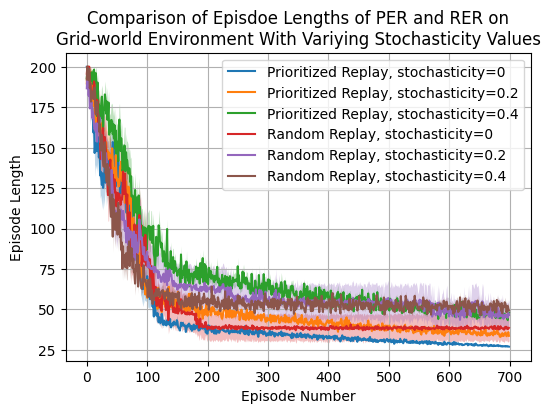

In [15]:
num_runs = 20
num_episodes = 700
indx = 0

# we separate the data regarding different hyperparameters for either of the algorihtms
rewards_prioritized = []
rewards_random = []
for i in range(3):
    rewards_prioritized.append(return_data_pr_np[i*num_runs:(i+1)*num_runs,indx])

for i in range(3):
    rewards_random.append(return_data_random_np[i*num_runs:(i+1)*num_runs,indx])

# Plotting
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.plot(np.mean(rewards_prioritized[i],axis=0), label=f'Prioritized Replay, stochasticity={stochasticity_constants_pr[i]}')
    std_err = np.std(rewards_prioritized[i], axis=0) / np.sqrt(np.size(rewards_prioritized[i], axis=0))
    lower_std = np.mean(rewards_prioritized[i],axis=0) - std_err
    upper_std = np.mean(rewards_prioritized[i],axis=0) + std_err
    plt.fill_between(range(1, num_episodes + 1), lower_std, upper_std, alpha=0.3)


for i in range(3):
    plt.plot(np.mean(rewards_random[i],axis=0), label=f'Random Replay, stochasticity={stochasticity_constants_random[i]}')
    std_err = np.std(rewards_random[i], axis=0) / np.sqrt(np.size(rewards_random[i], axis=0))
    lower_std = np.mean(rewards_random[i],axis=0) - std_err
    upper_std = np.mean(rewards_random[i],axis=0) + std_err
    plt.fill_between(range(1, num_episodes + 1), lower_std, upper_std, alpha=0.3)


plt.xlabel('Episode Number')
plt.ylabel('Episode Length')
plt.title('Comparison of Episdoe Lengths of PER and RER on\nGrid-world Environment With Variying Stochasticity Values')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# this helper function draws graphs for each individual stochasticity value

def draw_graphs(stochasticity_draw_indices):
    num_runs = 20
    num_episodes = 700
    indx = 0

    # we separate the data regarding different hyperparameters for either of the algorihtms
    rewards_prioritized = []
    rewards_random = []
    for i in range(3):
        rewards_prioritized.append(return_data_pr_np[i*num_runs:(i+1)*num_runs,indx])
    
    for i in range(3):
        rewards_random.append(return_data_random_np[i*num_runs:(i+1)*num_runs,indx])

    # Plotting
    plt.figure(figsize=(6, 4))
    for i in stochasticity_draw_indices:
        plt.plot(np.mean(rewards_prioritized[i],axis=0), label=f'Prioritized Replay, stochasticity={stochasticity_constants_pr[i]}')
        std_err = np.std(rewards_prioritized[i], axis=0) / np.sqrt(np.size(rewards_prioritized[i], axis=0))
        lower_std = np.mean(rewards_prioritized[i],axis=0) - std_err
        upper_std = np.mean(rewards_prioritized[i],axis=0) + std_err
        plt.fill_between(range(1, num_episodes + 1), lower_std, upper_std, alpha=0.3)

    for i in stochasticity_draw_indices:
        plt.plot(np.mean(rewards_random[i],axis=0), label=f'Random Replay, stochasticity={stochasticity_constants_random[i]}')
        std_err = np.std(rewards_random[i], axis=0) / np.sqrt(np.size(rewards_random[i], axis=0))
        lower_std = np.mean(rewards_random[i],axis=0) - std_err
        upper_std = np.mean(rewards_random[i],axis=0) + std_err
        plt.fill_between(range(1, num_episodes + 1), lower_std, upper_std, alpha=0.3)


    plt.xlabel('Episode Number')
    plt.ylabel('Episode Length')
    plt.title(f'Comparison of Episode Lengths of PER and RER \nGridworld Environment With Stochasticity={stochasticity_constants_random[stochasticity_draw_indices[0]]}')
    plt.legend()
    plt.xlim(0,700)
    plt.grid(True)
    plt.show()



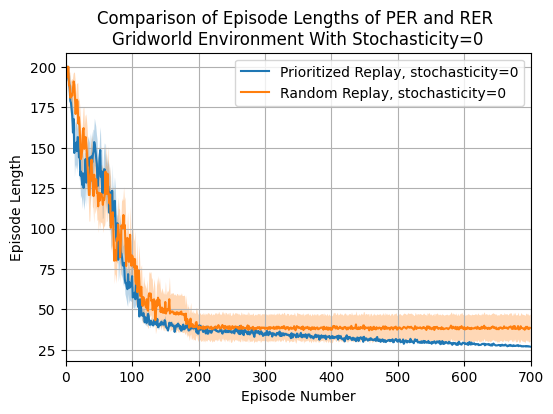

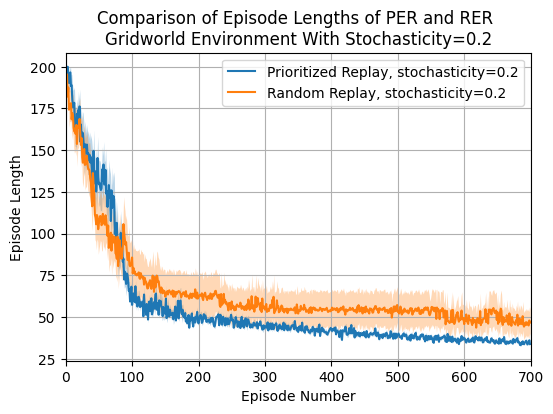

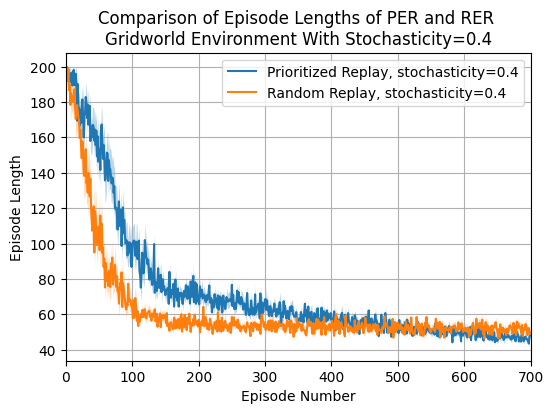

In [11]:
draw_graphs(stochasticity_draw_indices=[0])
draw_graphs(stochasticity_draw_indices=[1])
draw_graphs(stochasticity_draw_indices=[2])

### Average of last 10 episodes:

In [5]:
num_runs = 20
num_episodes = 700
indx = 0

rewards_prioritized = []
rewards_random = []
for i in range(3):
    rewards_prioritized.append(return_data_pr_np[i*num_runs:(i+1)*num_runs,indx])

for i in range(3):
    rewards_random.append(return_data_random_np[i*num_runs:(i+1)*num_runs,indx])

In [6]:
stochast_values = [0 , 0.2, 0.4]
print("experiment 2:")
for i in range(3):
    print(f"PER (stochasticity={stochast_values[i]}):", round(np.mean(np.mean(rewards_prioritized[i],axis=0)[-10:]),2))
    print(f"RER (stochasticity={stochast_values[i]}):", round(np.mean(np.mean(rewards_random[i],axis=0)[-10:]),2))

experiment 2:
PER (stochasticity=0): 27.24
RER (stochasticity=0): 38.42
PER (stochasticity=0.2): 34.64
RER (stochasticity=0.2): 45.94
PER (stochasticity=0.4): 46.16
RER (stochasticity=0.4): 51.39
